<a href="https://colab.research.google.com/github/manmeet3/Medical-SSL-SimCLRv2/blob/main/simclr_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab contains a first attempt at finetuning simclr for medical dataset.
To do: 
* Maybe follow through all the steps in simclr architecture to get best performance? pretrain -> finetune -> distill -> infer
* Wrap the model in a tfx pipeline

Chest X-ray exams are one of the most frequent and cost-effective medical imaging examinations available. However, clinical diagnosis of a chest X-ray can be challenging and sometimes more difficult than diagnosis via chest CT imaging. The lack of large publicly available datasets with annotations means it is still very difficult, if not impossible, to achieve clinically relevant computer-aided detection and diagnosis (CAD) in real world medical sites with chest X-rays. One major hurdle in creating large X-ray image datasets is the lack resources for labeling so many images. Prior to the release of this dataset, Openi was the largest publicly available source of chest X-ray images with 4,143 images available.

This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning. The original radiology reports are not publicly available but you can find more details on the labeling process in this Open Access paper: "ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases." (Wang et al.)

Source: Kaggle dataset description (https://www.kaggle.com/nih-chest-xrays/data)

SimCLRv2 reference colab: https://github.com/google-research/simclr/tree/master/colabs

In [ ]:
import os
import pandas as pd
import re
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shared\ drives/DL2-project/DL2_SimCLRv2_Medical_Classification

/content/drive/Shared drives/DL2-project/DL2_SimCLRv2_Medical_Classification


In [ ]:
!ls

Archive			data.zip	   LOG_CHESTXRAY.pdf
ARXIV_V5_CHESTXRAY.pdf	FAQ_CHESTXRAY.pdf  metadata
BBox_List_2017.csv	images_001	   README_CHESTXRAY.pdf
Data_Entry_2017.csv	images_002	   simclr_finetune.ipynb
Data_Entry_2017.gsheet	Links.gdoc


In [ ]:
#os.environ['KAGGLE_USERNAME'] = "manmeet3" # username from the json file
#os.environ['KAGGLE_KEY'] = "0948ff0e9e993e3c5d69de02ca1b882f" # key from the json file

In [ ]:
#!kaggle datasets download -d nih-chest-xrays/data

In [ ]:
#!mkdir images_003

In [ ]:
#unzip src.zip 'path/in/archive/**/*' -d "/target/dir/"
#!unzip data.zip "images_003/*" -d "./images_003"

In [ ]:
#!find ./images_001 -type f -print | wc -l
#!!du -h --max-depth=1 ./images_001/

4999


In [ ]:
!find ./images_002 -type f -print | wc -l
#!du -h --max-depth=1 ./images_002/

941


We have about 6000 images to train with. Probably good enough for now..

In [ ]:
disease_labels = [
"Atelectasis",
"Consolidation",
"Infiltration",
"Pneumothorax",
"Edema",
"Emphysema",
"Fibrosis",
"Effusion",
"Pneumonia",
"Pleural_thickening",
"Cardiomegaly",
"Nodule Mass",
"Hernia"
]

In [ ]:
# Ref: https://github.com/google-research/simclr/blob/master/colabs/finetuning.ipynb
#@title Preprocessing functions from data_util.py in SimCLR repository (hidden).

FLAGS_color_jitter_strength = 0.3
CROP_PROPORTION = 0.875  # Standard for ImageNet.


def random_apply(func, p, x):
  """Randomly apply function func to x with probability p."""
  return tf.cond(
      tf.less(tf.random_uniform([], minval=0, maxval=1, dtype=tf.float32),
              tf.cast(p, tf.float32)),
      lambda: func(x),
      lambda: x)


def random_brightness(image, max_delta, impl='simclrv2'):
  """A multiplicative vs additive change of brightness."""
  if impl == 'simclrv2':
    factor = tf.random_uniform(
        [], tf.maximum(1.0 - max_delta, 0), 1.0 + max_delta)
    image = image * factor
  elif impl == 'simclrv1':
    image = random_brightness(image, max_delta=max_delta)
  else:
    raise ValueError('Unknown impl {} for random brightness.'.format(impl))
  return image


def to_grayscale(image, keep_channels=True):
  image = tf.image.rgb_to_grayscale(image)
  if keep_channels:
    image = tf.tile(image, [1, 1, 3])
  return image


def color_jitter(image,
                 strength,
                 random_order=True):
  """Distorts the color of the image.
  Args:
    image: The input image tensor.
    strength: the floating number for the strength of the color augmentation.
    random_order: A bool, specifying whether to randomize the jittering order.
  Returns:
    The distorted image tensor.
  """
  brightness = 0.8 * strength
  contrast = 0.8 * strength
  saturation = 0.8 * strength
  hue = 0.2 * strength
  if random_order:
    return color_jitter_rand(image, brightness, contrast, saturation, hue)
  else:
    return color_jitter_nonrand(image, brightness, contrast, saturation, hue)


def color_jitter_nonrand(image, brightness=0, contrast=0, saturation=0, hue=0):
  """Distorts the color of the image (jittering order is fixed).
  Args:
    image: The input image tensor.
    brightness: A float, specifying the brightness for color jitter.
    contrast: A float, specifying the contrast for color jitter.
    saturation: A float, specifying the saturation for color jitter.
    hue: A float, specifying the hue for color jitter.
  Returns:
    The distorted image tensor.
  """
  with tf.name_scope('distort_color'):
    def apply_transform(i, x, brightness, contrast, saturation, hue):
      """Apply the i-th transformation."""
      if brightness != 0 and i == 0:
        x = random_brightness(x, max_delta=brightness)
      elif contrast != 0 and i == 1:
        x = tf.image.random_contrast(
            x, lower=1-contrast, upper=1+contrast)
      elif saturation != 0 and i == 2:
        x = tf.image.random_saturation(
            x, lower=1-saturation, upper=1+saturation)
      elif hue != 0:
        x = tf.image.random_hue(x, max_delta=hue)
      return x

    for i in range(4):
      image = apply_transform(i, image, brightness, contrast, saturation, hue)
      image = tf.clip_by_value(image, 0., 1.)
    return image


def color_jitter_rand(image, brightness=0, contrast=0, saturation=0, hue=0):
  """Distorts the color of the image (jittering order is random).
  Args:
    image: The input image tensor.
    brightness: A float, specifying the brightness for color jitter.
    contrast: A float, specifying the contrast for color jitter.
    saturation: A float, specifying the saturation for color jitter.
    hue: A float, specifying the hue for color jitter.
  Returns:
    The distorted image tensor.
  """
  with tf.name_scope('distort_color'):
    def apply_transform(i, x):
      """Apply the i-th transformation."""
      def brightness_foo():
        if brightness == 0:
          return x
        else:
          return random_brightness(x, max_delta=brightness)
      def contrast_foo():
        if contrast == 0:
          return x
        else:
          return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
      def saturation_foo():
        if saturation == 0:
          return x
        else:
          return tf.image.random_saturation(
              x, lower=1-saturation, upper=1+saturation)
      def hue_foo():
        if hue == 0:
          return x
        else:
          return tf.image.random_hue(x, max_delta=hue)
      x = tf.cond(tf.less(i, 2),
                  lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                  lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
      return x

    perm = tf.random_shuffle(tf.range(4))
    for i in range(4):
      image = apply_transform(perm[i], image)
      image = tf.clip_by_value(image, 0., 1.)
    return image


def _compute_crop_shape(
    image_height, image_width, aspect_ratio, crop_proportion):
  """Compute aspect ratio-preserving shape for central crop.
  The resulting shape retains `crop_proportion` along one side and a proportion
  less than or equal to `crop_proportion` along the other side.
  Args:
    image_height: Height of image to be cropped.
    image_width: Width of image to be cropped.
    aspect_ratio: Desired aspect ratio (width / height) of output.
    crop_proportion: Proportion of image to retain along the less-cropped side.
  Returns:
    crop_height: Height of image after cropping.
    crop_width: Width of image after cropping.
  """
  image_width_float = tf.cast(image_width, tf.float32)
  image_height_float = tf.cast(image_height, tf.float32)

  def _requested_aspect_ratio_wider_than_image():
    crop_height = tf.cast(tf.rint(
        crop_proportion / aspect_ratio * image_width_float), tf.int32)
    crop_width = tf.cast(tf.rint(
        crop_proportion * image_width_float), tf.int32)
    return crop_height, crop_width

  def _image_wider_than_requested_aspect_ratio():
    crop_height = tf.cast(
        tf.rint(crop_proportion * image_height_float), tf.int32)
    crop_width = tf.cast(tf.rint(
        crop_proportion * aspect_ratio *
        image_height_float), tf.int32)
    return crop_height, crop_width

  return tf.cond(
      aspect_ratio > image_width_float / image_height_float,
      _requested_aspect_ratio_wider_than_image,
      _image_wider_than_requested_aspect_ratio)


def center_crop(image, height, width, crop_proportion):
  """Crops to center of image and rescales to desired size.
  Args:
    image: Image Tensor to crop.
    height: Height of image to be cropped.
    width: Width of image to be cropped.
    crop_proportion: Proportion of image to retain along the less-cropped side.
  Returns:
    A `height` x `width` x channels Tensor holding a central crop of `image`.
  """
  shape = tf.shape(image)
  image_height = shape[0]
  image_width = shape[1]
  crop_height, crop_width = _compute_crop_shape(
      image_height, image_width, height / width, crop_proportion)
  offset_height = ((image_height - crop_height) + 1) // 2
  offset_width = ((image_width - crop_width) + 1) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_height, offset_width, crop_height, crop_width)

  image = tf.image.resize_bicubic([image], [height, width])[0]

  return image


def distorted_bounding_box_crop(image,
                                bbox,
                                min_object_covered=0.1,
                                aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0),
                                max_attempts=100,
                                scope=None):
  """Generates cropped_image using one of the bboxes randomly distorted.
  See `tf.image.sample_distorted_bounding_box` for more documentation.
  Args:
    image: `Tensor` of image data.
    bbox: `Tensor` of bounding boxes arranged `[1, num_boxes, coords]`
        where each coordinate is [0, 1) and the coordinates are arranged
        as `[ymin, xmin, ymax, xmax]`. If num_boxes is 0 then use the whole
        image.
    min_object_covered: An optional `float`. Defaults to `0.1`. The cropped
        area of the image must contain at least this fraction of any bounding
        box supplied.
    aspect_ratio_range: An optional list of `float`s. The cropped area of the
        image must have an aspect ratio = width / height within this range.
    area_range: An optional list of `float`s. The cropped area of the image
        must contain a fraction of the supplied image within in this range.
    max_attempts: An optional `int`. Number of attempts at generating a cropped
        region of the image of the specified constraints. After `max_attempts`
        failures, return the entire image.
    scope: Optional `str` for name scope.
  Returns:
    (cropped image `Tensor`, distorted bbox `Tensor`).
  """
  with tf.name_scope(scope, 'distorted_bounding_box_crop', [image, bbox]):
    shape = tf.shape(image)
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes=bbox,
        min_object_covered=min_object_covered,
        aspect_ratio_range=aspect_ratio_range,
        area_range=area_range,
        max_attempts=max_attempts,
        use_image_if_no_bounding_boxes=True)
    bbox_begin, bbox_size, _ = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    offset_y, offset_x, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, target_height, target_width)

    return image


def crop_and_resize(image, height, width):
  """Make a random crop and resize it to height `height` and width `width`.
  Args:
    image: Tensor representing the image.
    height: Desired image height.
    width: Desired image width.
  Returns:
    A `height` x `width` x channels Tensor holding a random crop of `image`.
  """
  bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
  aspect_ratio = width / height
  image = distorted_bounding_box_crop(
      image,
      bbox,
      min_object_covered=0.1,
      aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
      area_range=(0.08, 1.0),
      max_attempts=100,
      scope=None)
  return tf.image.resize_bicubic([image], [height, width])[0]


def gaussian_blur(image, kernel_size, sigma, padding='SAME'):
  """Blurs the given image with separable convolution.
  Args:
    image: Tensor of shape [height, width, channels] and dtype float to blur.
    kernel_size: Integer Tensor for the size of the blur kernel. This is should
      be an odd number. If it is an even number, the actual kernel size will be
      size + 1.
    sigma: Sigma value for gaussian operator.
    padding: Padding to use for the convolution. Typically 'SAME' or 'VALID'.
  Returns:
    A Tensor representing the blurred image.
  """
  radius = tf.to_int32(kernel_size / 2)
  kernel_size = radius * 2 + 1
  x = tf.to_float(tf.range(-radius, radius + 1))
  blur_filter = tf.exp(
      -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.to_float(sigma), 2.0)))
  blur_filter /= tf.reduce_sum(blur_filter)
  # One vertical and one horizontal filter.
  blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
  blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
  num_channels = tf.shape(image)[-1]
  blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
  blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
  expand_batch_dim = image.shape.ndims == 3
  if expand_batch_dim:
    # Tensorflow requires batched input to convolutions, which we can fake with
    # an extra dimension.
    image = tf.expand_dims(image, axis=0)
  blurred = tf.nn.depthwise_conv2d(
      image, blur_h, strides=[1, 1, 1, 1], padding=padding)
  blurred = tf.nn.depthwise_conv2d(
      blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
  if expand_batch_dim:
    blurred = tf.squeeze(blurred, axis=0)
  return blurred


def random_crop_with_resize(image, height, width, p=1.0):
  """Randomly crop and resize an image.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    p: Probability of applying this transformation.
  Returns:
    A preprocessed image `Tensor`.
  """
  def _transform(image):  # pylint: disable=missing-docstring
    image = crop_and_resize(image, height, width)
    return image
  return random_apply(_transform, p=p, x=image)


def random_color_jitter(image, p=1.0):
  def _transform(image):
    color_jitter_t = functools.partial(
        color_jitter, strength=FLAGS_color_jitter_strength)
    image = random_apply(color_jitter_t, p=0.8, x=image)
    return random_apply(to_grayscale, p=0.2, x=image)
  return random_apply(_transform, p=p, x=image)


def random_blur(image, height, width, p=1.0):
  """Randomly blur an image.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    p: probability of applying this transformation.
  Returns:
    A preprocessed image `Tensor`.
  """
  del width
  def _transform(image):
    sigma = tf.random.uniform([], 0.1, 2.0, dtype=tf.float32)
    return gaussian_blur(
        image, kernel_size=height//10, sigma=sigma, padding='SAME')
  return random_apply(_transform, p=p, x=image)


def batch_random_blur(images_list, height, width, blur_probability=0.5):
  """Apply efficient batch data transformations.
  Args:
    images_list: a list of image tensors.
    height: the height of image.
    width: the width of image.
    blur_probability: the probaility to apply the blur operator.
  Returns:
    Preprocessed feature list.
  """
  def generate_selector(p, bsz):
    shape = [bsz, 1, 1, 1]
    selector = tf.cast(
        tf.less(tf.random_uniform(shape, 0, 1, dtype=tf.float32), p),
        tf.float32)
    return selector

  new_images_list = []
  for images in images_list:
    images_new = random_blur(images, height, width, p=1.)
    selector = generate_selector(blur_probability, tf.shape(images)[0])
    images = images_new * selector + images * (1 - selector)
    images = tf.clip_by_value(images, 0., 1.)
    new_images_list.append(images)

  return new_images_list


def preprocess_for_train(image, height, width,
                         color_distort=True, crop=True, flip=True):
  """Preprocesses the given image for training.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    color_distort: Whether to apply the color distortion.
    crop: Whether to crop the image.
    flip: Whether or not to flip left and right of an image.
  Returns:
    A preprocessed image `Tensor`.
  """
  if crop:
    image = random_crop_with_resize(image, height, width)
  if flip:
    image = tf.image.random_flip_left_right(image)
  if color_distort:
    image = random_color_jitter(image)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image


def preprocess_for_eval(image, height, width, crop=True):
  """Preprocesses the given image for evaluation.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    crop: Whether or not to (center) crop the test images.
  Returns:
    A preprocessed image `Tensor`.
  """
  if crop:
    image = center_crop(image, height, width, crop_proportion=CROP_PROPORTION)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image


def preprocess_image(image, height, width, is_training=False,
                     color_distort=True, test_crop=True):
  """Preprocesses the given image.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    is_training: `bool` for whether the preprocessing is for training.
    color_distort: whether to apply the color distortion.
    test_crop: whether or not to extract a central crop of the images
        (as for standard ImageNet evaluation) during the evaluation.
  Returns:
    A preprocessed image `Tensor` of range [0, 1].
  """
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  if is_training:
    return preprocess_for_train(image, height, width, color_distort)
  else:
    return preprocess_for_eval(image, height, width, test_crop)

In [ ]:
#Ref: https://github.com/google-research/simclr/blob/master/colabs/finetuning.ipynb
#@title LARS optimizer from data_util.py in SimCLR repository (hidden).

EETA_DEFAULT = 0.001

class LARSOptimizer(tf.train.Optimizer):
  """Layer-wise Adaptive Rate Scaling for large batch training.

  Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
  I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
  """

  def __init__(self,
               learning_rate,
               momentum=0.9,
               use_nesterov=False,
               weight_decay=0.0,
               exclude_from_weight_decay=None,
               exclude_from_layer_adaptation=None,
               classic_momentum=True,
               eeta=EETA_DEFAULT,
               name="LARSOptimizer"):
    """Constructs a LARSOptimizer.

    Args:
      learning_rate: A `float` for learning rate.
      momentum: A `float` for momentum.
      use_nesterov: A 'Boolean' for whether to use nesterov momentum.
      weight_decay: A `float` for weight decay.
      exclude_from_weight_decay: A list of `string` for variable screening, if
          any of the string appears in a variable's name, the variable will be
          excluded for computing weight decay. For example, one could specify
          the list like ['batch_normalization', 'bias'] to exclude BN and bias
          from weight decay.
      exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
          for layer adaptation. If it is None, it will be defaulted the same as
          exclude_from_weight_decay.
      classic_momentum: A `boolean` for whether to use classic (or popular)
          momentum. The learning rate is applied during momeuntum update in
          classic momentum, but after momentum for popular momentum.
      eeta: A `float` for scaling of learning rate when computing trust ratio.
      name: The name for the scope.
    """
    super(LARSOptimizer, self).__init__(False, name)

    self.learning_rate = learning_rate
    self.momentum = momentum
    self.weight_decay = weight_decay
    self.use_nesterov = use_nesterov
    self.classic_momentum = classic_momentum
    self.eeta = eeta
    self.exclude_from_weight_decay = exclude_from_weight_decay
    # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
    # arg is None.
    if exclude_from_layer_adaptation:
      self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
    else:
      self.exclude_from_layer_adaptation = exclude_from_weight_decay

  def apply_gradients(self, grads_and_vars, global_step=None, name=None):
    if global_step is None:
      global_step = tf.train.get_or_create_global_step()
    new_global_step = global_step + 1

    assignments = []
    for (grad, param) in grads_and_vars:
      if grad is None or param is None:
        continue

      param_name = param.op.name

      v = tf.get_variable(
          name=param_name + "/Momentum",
          shape=param.shape.as_list(),
          dtype=tf.float32,
          trainable=False,
          initializer=tf.zeros_initializer())

      if self._use_weight_decay(param_name):
        grad += self.weight_decay * param

      if self.classic_momentum:
        trust_ratio = 1.0
        if self._do_layer_adaptation(param_name):
          w_norm = tf.norm(param, ord=2)
          g_norm = tf.norm(grad, ord=2)
          trust_ratio = tf.where(
              tf.greater(w_norm, 0), tf.where(
                  tf.greater(g_norm, 0), (self.eeta * w_norm / g_norm),
                  1.0),
              1.0)
        scaled_lr = self.learning_rate * trust_ratio

        next_v = tf.multiply(self.momentum, v) + scaled_lr * grad
        if self.use_nesterov:
          update = tf.multiply(self.momentum, next_v) + scaled_lr * grad
        else:
          update = next_v
        next_param = param - update
      else:
        next_v = tf.multiply(self.momentum, v) + grad
        if self.use_nesterov:
          update = tf.multiply(self.momentum, next_v) + grad
        else:
          update = next_v

        trust_ratio = 1.0
        if self._do_layer_adaptation(param_name):
          w_norm = tf.norm(param, ord=2)
          v_norm = tf.norm(update, ord=2)
          trust_ratio = tf.where(
              tf.greater(w_norm, 0), tf.where(
                  tf.greater(v_norm, 0), (self.eeta * w_norm / v_norm),
                  1.0),
              1.0)
        scaled_lr = trust_ratio * self.learning_rate
        next_param = param - scaled_lr * update

      assignments.extend(
          [param.assign(next_param),
           v.assign(next_v),
           global_step.assign(new_global_step)])
    return tf.group(*assignments, name=name)

  def _use_weight_decay(self, param_name):
    """Whether to use L2 weight decay for `param_name`."""
    if not self.weight_decay:
      return False
    if self.exclude_from_weight_decay:
      for r in self.exclude_from_weight_decay:
        if re.search(r, param_name) is not None:
          return False
    return True

  def _do_layer_adaptation(self, param_name):
    """Whether to do layer-wise learning rate adaptation for `param_name`."""
    if self.exclude_from_layer_adaptation:
      for r in self.exclude_from_layer_adaptation:
        if re.search(r, param_name) is not None:
          return False
    return True

In [ ]:
# load both csvs that contain labels into dataframes

In [ ]:
# Create tf dataset objects compatible with the model 

In [ ]:
!ls

Archive			data.zip	   LOG_CHESTXRAY.pdf
ARXIV_V5_CHESTXRAY.pdf	FAQ_CHESTXRAY.pdf  metadata
BBox_List_2017.csv	images_001	   README_CHESTXRAY.pdf
Data_Entry_2017.csv	images_002	   simclr_finetune.ipynb
Data_Entry_2017.gsheet	Links.gdoc


In [ ]:
labels_df = pd.read_csv("Data_Entry_2017.csv")

In [ ]:
labels_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [ ]:
labels_df.shape

(112120, 12)

In [ ]:
# Downsample the No Finding class to take 20% of it
# Ref: https://www.kaggle.com/kmader/train-simple-xray-cnn
mask = labels_df['Finding Labels'] != 'No Finding'
ctr = 0
for i in range(mask.shape[0]):
  ctr+=1
  if ctr%5==0:
    mask[i]=1

labels_df = labels_df[mask].copy(deep=True)

In [ ]:
labels_df.shape

(63846, 12)

In [ ]:
from glob import glob

In [ ]:
all_image_paths = {os.path.basename(f):f for f in glob(os.path.join("./", 'images*', '*', '*.png'))}
print('Images found: ', len(all_image_paths), ', Total Headers', labels_df.shape[0])
labels_df['path'] = labels_df['Image Index'].map(all_image_paths.get)
labels_df.sample(3)

Images found:  5940 , Total Headers 63846


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
61925,00015314_000.png,Effusion|Infiltration,0,15314,53,F,AP,2048,2500,0.168,0.168,NaN,None
14305,00003709_009.png,Infiltration|Nodule,9,3709,54,F,PA,2992,2991,0.143,0.143,NaN,None
83439,00020482_025.png,Infiltration|Pneumonia,25,20482,29,F,AP,2500,2048,0.168,0.168,NaN,None


In [ ]:
new_df = labels_df[labels_df['path'].notna()]

In [ ]:
new_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,NaN,./images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,NaN,./images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000,NaN,./images_001/images/00000001_002.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143000,0.143000,NaN,./images_001/images/00000003_000.png
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168000,0.168000,NaN,./images_001/images/00000003_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5934,00001601_004.png,No Finding,4,1601,65,F,PA,2021,2020,0.194311,0.194311,NaN,./images_002/images/00001601_004.png
5936,00001601_006.png,Edema,6,1601,56,F,AP,2500,2048,0.168000,0.168000,NaN,./images_002/images/00001601_006.png
5937,00001601_007.png,Atelectasis,7,1601,56,F,AP,2500,2048,0.168000,0.168000,NaN,./images_002/images/00001601_007.png
5938,00001601_008.png,Edema|Effusion|Infiltration,8,1601,56,F,PA,2992,2991,0.143000,0.143000,NaN,./images_002/images/00001601_008.png


One key issue we are facing is how to deal with multiple labels for a given image?? Take the first label .. or ?

Preprocessing Labels

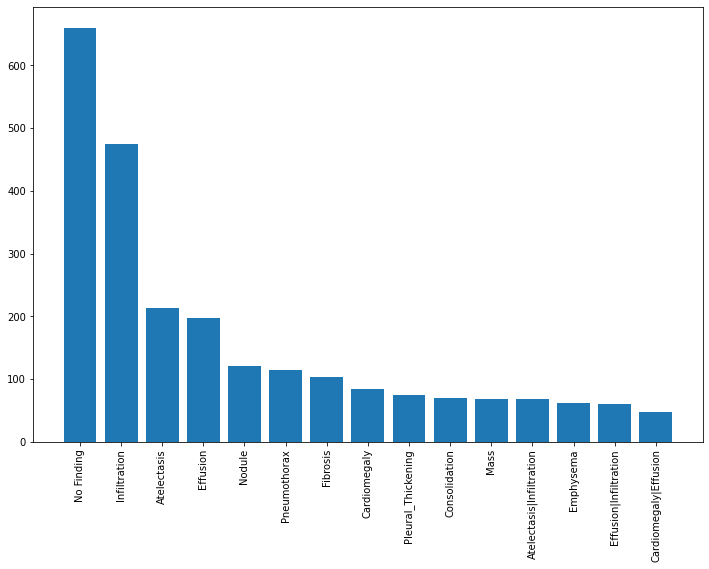

In [ ]:
label_counts = new_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1, 1, figsize = (12,8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [ ]:
new_df['Finding Labels'] = new_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*new_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
  if len(c_label)>1:
    new_df[c_label] = new_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
new_df.sample(3)

All Labels(14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2589,00000675_000.png,,0,675,58,M,PA,2798,2991,0.143,0.143,NaN,./images_001/images/00000675_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3447,00000924_000.png,Fibrosis,0,924,47,F,PA,2048,2500,0.168,0.168,NaN,./images_001/images/00000924_000.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2228,00000583_018.png,Consolidation|Effusion,18,583,40,F,AP,2500,2048,0.168,0.168,NaN,./images_001/images/00000583_018.png,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


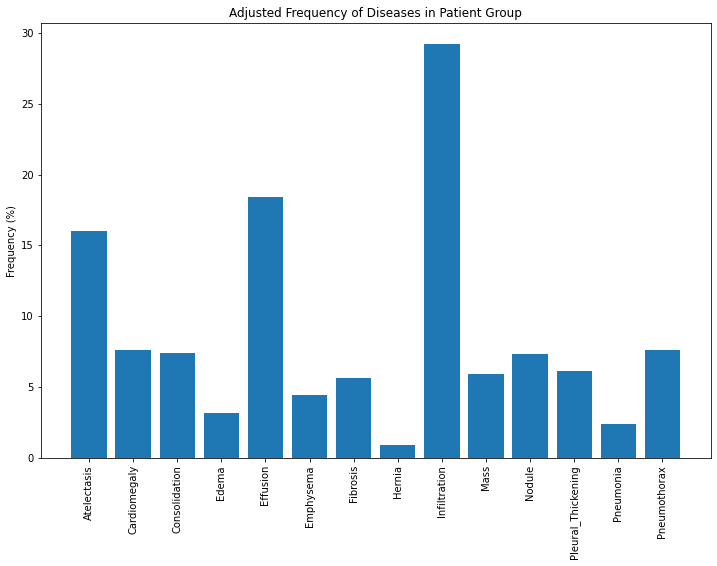

In [ ]:
label_counts = 100*np.mean(new_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

##Prepare Training Data

Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [ ]:
new_df['disease_vec'] = new_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
new_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,./images_001/images/00000001_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,./images_001/images/00000001_001.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,./images_001/images/00000001_002.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,./images_001/images/00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN,./images_001/images/00000003_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


At this point, I may want to organize the data directory based on https://www.tensorflow.org/datasets/api_docs/python/tfds/folder_dataset/ImageFolder

References:
https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community

https://github.com/google-research/simclr/blob/master/colabs/finetuning.ipynb